In [20]:
from ctrade import *
from plot import *
from datetime import datetime
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [21]:
p = Poloniex()

In [22]:
major = ['ETH', 'ETC', 'BCN', 'DASH', 'DOGE', 'LTC', 'NXT', 'REP', 'ZEC', 'ARDR', 'XRP', 'STR']

In [23]:
pairs = [i for i in p.currency_pairs if 'USDT_' in i]
pairs += [i for i in p.currency_pairs if any([j for j in major if 'BTC_'+j in i])]

In [24]:
inf = lambda x: np.isinf(x)

def build_dataset(currency_pairs, days_back, period):
    out = pd.DataFrame()
    for i in currency_pairs:
        print(i)
        t = p.chart(i, days_back, period).df
        t[i+'_PC'] = (t['close'] - t['close'].shift(1))/t['close']
        t = t.rename(columns={'close': i})
        t[i+'_volume'] = t['volume']
        t[i+'_volume_PC'] = (t[i+'_volume'] - t[i+'_volume'].shift(1))/t[i+'_volume']
        t[i+'_volume_PC'] = t[i+'_volume_PC'].fillna(0)
        mask = t[i+'_volume_PC'].apply(inf)
        t.loc[mask, i+'_volume_PC'] = 0
        out = pd.concat([out, t[[i+'_PC', i+'_volume_PC', i, i+'_volume']]], axis=1)
    
    df = out[currency_pairs + [i+'_volume' for i in currency_pairs]]
    out = out[out[i+'_PC'].notnull()]
    return out[[i for i in out.columns if i not in currency_pairs]], df

In [27]:
df = p.chart('BTC_XRP', 60, '15m').df
df['value'] = (df['open'] + df['close'])*0.5

This dictionary set the parameter for the indicators which I am using to build my model.
Daily or weekly pivot levels are used. 

In [28]:
indicators = {
    'macd': ('macd', {'slow_window': 50, 'fast_window': 15}),
    'rsi': ('rsi', {'window': 15}),
    'fstoc': ('fstoc', {'k_smooth': 8, 'd_smooth': 3}),
    'atr': ('atr', None),
    'bbands': ('bbands', {'mode':'spread'}),
    'pivot_daily': ('pivot', {'mode': 'day'}),
    'pivot_weekly': ('pivot', {'mode': 'week'}),
    'consecutive_periods': ('consecutive_periods', {'add_periods': ['1h', '4h']}),
}

In [29]:
class Model(object):
    
    def __init__(self, indicators, currency):
        self.indicators = indicators
        self.currency = currency
        self.indicator_func = {}
        
    def set_indicators(self):
        
        def feed(x):
            return {} if x is None else x
        
        for k,v in self.indicators.items():
            if v[0] in ['macd', 'rsi', 'bbands', 'pivot', 'consecutive_periods']:
                self.indicator_func[k] = with_series(self.currency)(indicator_partial(globals()[v[0]], **feed(v[1])))
            else:
                self.indicator_func[k] = indicator_partial(globals()[v[0]], **feed(v[1]))
        
    def get_data(self, df):
        
        return reduce(lambda x,y: pd.concat([x,y], axis=1), 
                      [func(df) for func in self.indicator_func.values()])
    
    def get_target(self, Y, span=[2, 5, 10, 25, 50, 100]):
        
        _Y = pd.DataFrame(index=Y.index)
        for s in span:
            _Y[s] = np.nan
            _Y.iloc[:-s, -1] = (Y - Y.shift(s)).iloc[s:].values
        return _Y

In [30]:
m = Model(indicators, 'value')
m.set_indicators()

This is the dataset to build the model on where all indicators are calculated at each timeframe.

In [31]:
X = m.get_data(df).dropna()
X.tail(20)

Calculating weekly pivot levels
Calculating daily pivot levels


,P_week_diff,R1_week_diff,S1_week_diff,R2_week_diff,S2_week_diff,R3_week_diff,S3_week_diff,rsi_15,bbands_20,conseq_up,...,atr_14,%D_14,%K_14,P_day_diff,R1_day_diff,S1_day_diff,R2_day_diff,S2_day_diff,R3_day_diff,S3_day_diff
2017-06-10 14:00:00,-0.000023,-0.000049,0.000003,-0.000075,0.000028,-0.000127,0.000080,19.402202,0.101576,1,...,0.000002,31.741459,35.635597,-0.000010,-0.000012,-0.000006,-0.000015,-0.000004,-0.000020,9.983333e-07
2017-06-10 14:15:00,-0.000023,-0.000049,0.000003,-0.000075,0.000028,-0.000127,0.000080,19.351464,0.101137,0,...,0.000002,34.838827,38.062388,-0.000010,-0.000012,-0.000006,-0.000015,-0.000004,-0.000020,8.783333e-07
2017-06-10 14:30:00,-0.000023,-0.000049,0.000003,-0.000075,0.000029,-0.000126,0.000080,24.079320,0.099045,1,...,0.000002,39.195372,43.888131,-0.000010,-0.000011,-0.000006,-0.000015,-0.000004,-0.000020,1.153333e-06
2017-06-10 14:45:00,-0.000022,-0.000048,0.000004,-0.000074,0.000029,-0.000126,0.000081,29.171095,0.096061,2,...,0.000002,42.645784,45.986835,-0.000009,-0.000011,-0.000005,-0.000014,-0.000004,-0.000020,1.773333e-06
2017-06-10 15:00:00,-0.000022,-0.000047,0.000004,-0.000074,0.000030,-0.000125,0.000081,33.982573,0.092121,3,...,0.000002,46.620681,49.987079,-0.000008,-0.000010,-0.000005,-0.000014,-0.000003,-0.000019,2.343333e-06
2017-06-10 15:15:00,-0.000022,-0.000047,0.000005,-0.000073,0.000030,-0.000125,0.000082,39.935414,0.083575,4,...,0.000002,49.934782,53.830433,-0.000008,-0.000010,-0.000005,-0.000013,-0.000003,-0.000019,2.738333e-06
2017-06-10 15:30:00,-0.000022,-0.000048,0.000004,-0.000074,0.000029,-0.000125,0.000081,39.892473,0.073524,0,...,0.000002,54.071030,58.395579,-0.000009,-0.000011,-0.000005,-0.000014,-0.000003,-0.000019,2.038333e-06
2017-06-10 15:45:00,-0.000022,-0.000047,0.000004,-0.000074,0.000030,-0.000125,0.000081,47.069168,0.066006,1,...,0.000002,58.736903,63.984697,-0.000008,-0.000010,-0.000005,-0.000014,-0.000003,-0.000019,2.343333e-06
2017-06-10 16:00:00,-0.000021,-0.000047,0.000005,-0.000073,0.000030,-0.000125,0.000082,51.960784,0.057028,2,...,0.000002,63.439100,67.937025,-0.000008,-0.000010,-0.000004,-0.000013,-0.000003,-0.000019,2.833333e-06
2017-06-10 16:15:00,-0.000022,-0.000047,0.000005,-0.000073,0.000030,-0.000125,0.000082,57.535121,0.046914,0,...,0.000002,67.613293,70.918157,-0.000008,-0.000010,-0.000005,-0.000013,-0.000003,-0.000019,2.728333e-06


Here I am calculating the price difference of the crypto pair at different periods to build the model. You can see here I am using 2, 5, 10, 25, 50 and 100 periods.

In [32]:
Y = m.get_target(df['value']).dropna()
Y.tail(20)

,2,5,10,25,50,100
2017-06-09 13:00:00,-4.950000e-07,-9.000000e-07,-2.030000e-06,-1.910000e-06,-2.310000e-06,-0.000010
2017-06-09 13:15:00,-3.500000e-07,-1.020000e-06,-1.435000e-06,-1.005000e-06,-2.460000e-06,-0.000010
2017-06-09 13:30:00,-2.650000e-07,-1.375000e-06,-1.210000e-06,-1.050000e-06,-2.575000e-06,-0.000010
2017-06-09 13:45:00,-2.550000e-07,-1.460000e-06,-1.065000e-06,-8.800000e-07,-2.855000e-06,-0.000009
2017-06-09 14:00:00,-5.550000e-07,-1.325000e-06,-6.150000e-07,-1.110000e-06,-2.320000e-06,-0.000008
2017-06-09 14:15:00,-9.700000e-07,-1.130000e-06,-1.000000e-08,-9.400000e-07,-2.215000e-06,-0.000008
2017-06-09 14:30:00,-7.900000e-07,-4.150000e-07,3.950000e-07,-2.100000e-07,-2.025000e-06,-0.000008
2017-06-09 14:45:00,-2.150000e-07,1.650000e-07,7.400000e-07,3.700000e-07,-1.500000e-06,-0.000007
2017-06-09 15:00:00,7.500000e-08,3.950000e-07,7.700000e-07,3.850000e-07,-1.005000e-06,-0.000007
2017-06-09 15:15:00,3.550000e-07,7.100000e-07,4.950000e-07,2.350000e-07,-5.850000e-07,-0.000007


In [33]:
mask = Y.index.isin(X.index)
save_last_Y = Y[~mask] 
Y = Y[mask]

mask = X.index.isin(Y.index)
save_last = X[~mask] 
X = X[mask]

In [34]:
X.shape[0], Y.shape[0], save_last.shape[0]

(5160, 5160, 100)

Here I am choosing to build the first model using the 5 period value difference (aka the price difference from each timeframe and that of 5 period later, 1h15m)

In [35]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from model_utils import *
from preprocessing import *

if len(Y[5].unique())>2:
    est = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, max_depth=4)
    est = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=4)
else:
    est = RandomForestClassifier(n_estimators=50, min_samples_leaf=10, max_depth=3)
#     est = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=10, max_depth=4)   

res = do_easy_crossval(est, X, Y[5]*1000, folds=10, refit=True)
pred = res[0]
est = res[1]

Trained fold 1
Trained fold 2
Trained fold 3
Trained fold 4
Trained fold 5
Trained fold 6
Trained fold 7
Trained fold 8
Trained fold 9
Trained fold 10


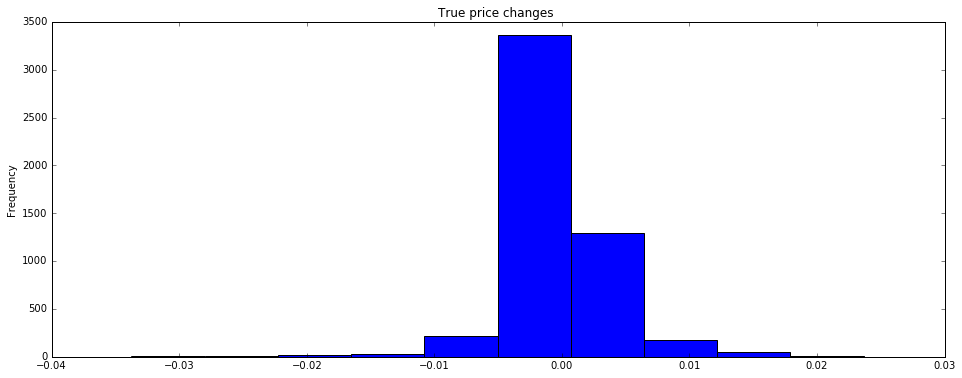

In [36]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
pred['true'].plot(kind='hist', ax=ax)
ax.set_title('True price changes ')

0.68372437397488517

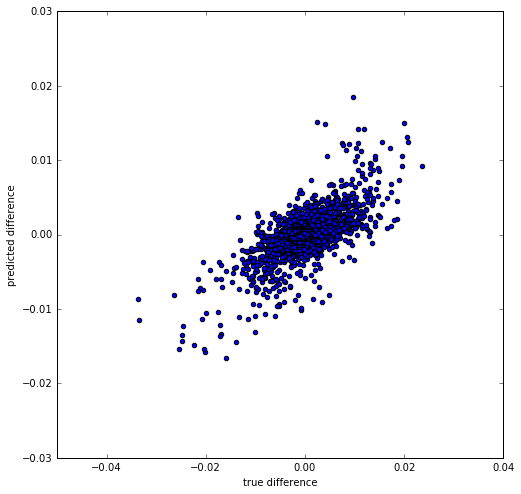

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(pred['true'], pred['pred'])
ax.set_xlabel('true difference')
ax.set_ylabel('predicted difference')

np.corrcoef(pred['true'], pred['pred'])[0][1]

The correlattion between the change in the cryptocurrency value and the predicted one is quite good as you can see from the scatter plot. Note that the predicted value are always out of sample and the model was not build on the point where it is predicting.

Below you can see which are the indicators sorted by there contribution to the overall prediction.

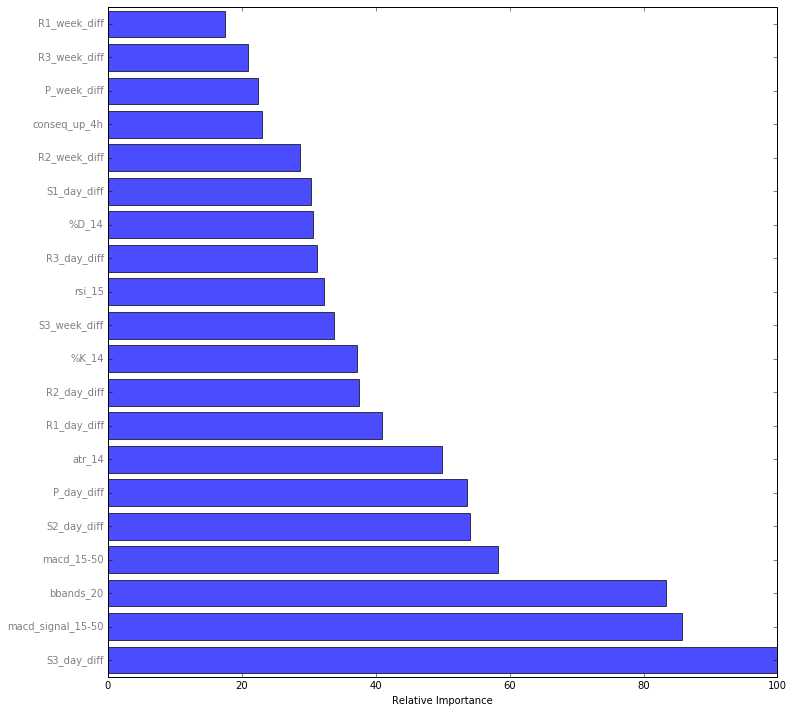

In [38]:
plot_feature_importances(est, X.columns, top=20)

Ideally one would use a combination of the predicted differences at different timeframes to base the buy-sell strategy.

I am going to add to this the following:
    * same indicators for another cryptocurrency, such as USD_BCT as I thing there is signal also there
    * Wrap mode that one model together and calibrate
    * Create a probabilistic model to output a probability
    

In [39]:
def simulate_sell(x, prices):
    state = ['start']
    profit = ['start']
    sell_price = []
    for index in range(len(x)):
        if state[-1]=='S' and x[index]==1:
            gain = (sell_price - prices[index])/sell_price
            profit.append(gain)
            state.append('C'),
        elif (state[-1]=='C' or state[-1]=='start') and x[index]==-1 :
            state.append('S')
            sell_price = prices[index]

    return state, profit

def simulate_buy(x, prices):
    state = ['start']
    profit = ['start']
    sell_price = []
    for index in range(len(x)):
        if state[-1]=='B' and x[index]==-1:
            gain = (prices[index] - sell_price)/sell_price
            profit.append(gain)
            state.append('C'),
        elif (state[-1]=='C' or state[-1]=='start') and x[index]==1 :
            state.append('B')
            sell_price = prices[index]

    return state, profit

def simulate_buy_sell(x, prices, dates):
    state = ['start']
    profit = ['start']
    sell_price = []
    date = []
    for index in range(len(x)):
        if state[-1]=='B' and x[index]==-1:
            gain = (prices[index] - sell_price)/sell_price
            print 'CB', prices[index], gain
            profit.append(gain)
            state.append('C'),
            date[-1] += [dates[index]]
        elif (state[-1]=='C' or state[-1]=='start') and x[index]==1 :
            state.append('B')
            sell_price = prices[index]
            print 'B', prices[index]
            date.append(['B', dates[index]])
        elif state[-1]=='S' and x[index]==1:
            gain = (sell_price - prices[index])/sell_price
            profit.append(gain)
            state.append('C')
            print 'CS', prices[index], gain
            date[-1] += [dates[index]]
        elif (state[-1]=='C' or state[-1]=='start') and x[index]==-1 :
            state.append('S')
            sell_price = prices[index]
            print 'S', prices[index]
            date.append(['S', dates[index]])

            
    return state, profit, date